# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.53KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

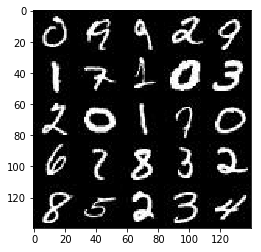

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

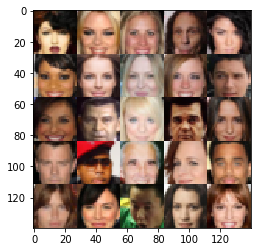

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 32x32x3 now

        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import os

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):    
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')
    
    # TODO: Build Model
    n, h, w, d = data_shape
    input_real, input_z, learning_rate_ph = model_inputs(h, w, d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    samples, losses = [], []
    steps = 0    
    print_every = 10
    show_every = 100
    n_images = 16
    
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # scale images from [-0.5, 0.5] to [0.0, 1,0]
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                                input_z: batch_z,
                                                learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                                input_real: batch_images,
                                                learning_rate_ph: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, d, data_image_mode)
  
        print('saving generator.ckpt')
        saver.save(sess, './checkpoints/generator.ckpt')                     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.9170... Generator Loss: 0.0029
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.3869
Epoch 1/2... Discriminator Loss: 0.0270... Generator Loss: 4.9237
Epoch 1/2... Discriminator Loss: 0.0091... Generator Loss: 8.7214
Epoch 1/2... Discriminator Loss: 0.3261... Generator Loss: 1.8249
Epoch 1/2... Discriminator Loss: 3.5898... Generator Loss: 0.3391
Epoch 1/2... Discriminator Loss: 0.5278... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 2.8213... Generator Loss: 16.8131
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 9.9494


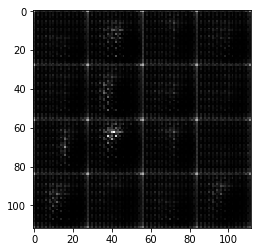

Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 0.3030... Generator Loss: 2.5679
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 0.6878... Generator Loss: 1.7153
Epoch 1/2... Discriminator Loss: 2.3816... Generator Loss: 6.0908
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 1.2701
Epoch 1/2... Discriminator Loss: 0.5121... Generator Loss: 2.3481
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 3.2749


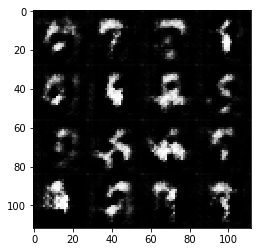

Epoch 1/2... Discriminator Loss: 0.6644... Generator Loss: 1.4596
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.5899
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.2252
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.0994
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 1.0653
Epoch 1/2... Discriminator Loss: 0.8293... Generator Loss: 1.1912
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 3.9797
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 1.0942


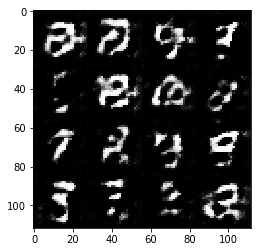

Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 1.1277
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 1.9055
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 1.0392
Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 0.8350... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 1.7646
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 2.2743
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.4423
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.6299


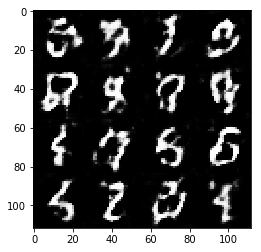

Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.8348
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 1.3151
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 1.5351
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.4756
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.5410
Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 1.3490


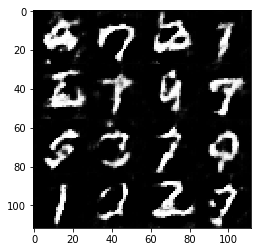

Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 1.4039
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.3347
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.6655
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.7055
Epoch 1/2... Discriminator Loss: 1.5457... Generator Loss: 2.7725
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.7562... Generator Loss: 0.2522
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 0.8217


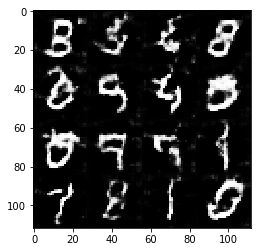

Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 1.7937
Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 2.6797
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 1.2232
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 1.5426
Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 0.5175
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.0929
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 0.7446


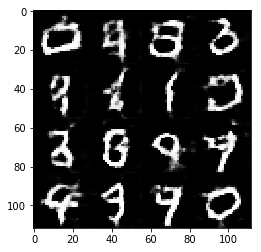

Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.8187... Generator Loss: 0.3060
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.9407
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 1.7162... Generator Loss: 2.6950
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 0.6411


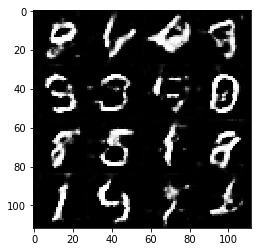

Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 1.6744
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 2.0607
Epoch 1/2... Discriminator Loss: 1.6877... Generator Loss: 2.5714
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 1.3851


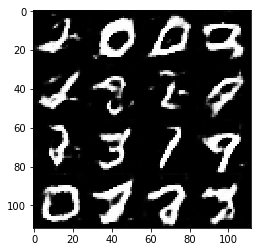

Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.3933
Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.5643
Epoch 2/2... Discriminator Loss: 0.8338... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.2156
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.5603
Epoch 2/2... Discriminator Loss: 1.6365... Generator Loss: 0.2990
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 0.7193


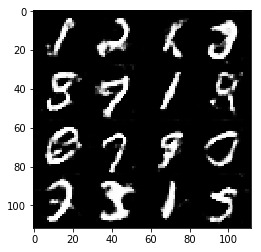

Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.2530
Epoch 2/2... Discriminator Loss: 0.6469... Generator Loss: 1.6131
Epoch 2/2... Discriminator Loss: 0.8414... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 2.5048... Generator Loss: 0.1177
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 0.6501
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 2.0573
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.1364


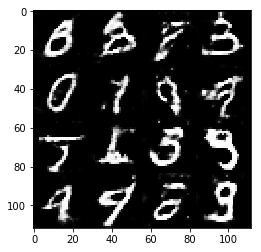

Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 1.9649
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 1.4082
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.5247
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 0.9868


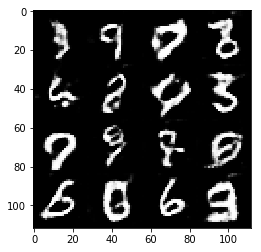

Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.3153
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 0.5000
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 0.7878... Generator Loss: 0.9366
Epoch 2/2... Discriminator Loss: 2.1256... Generator Loss: 0.2237
Epoch 2/2... Discriminator Loss: 0.7764... Generator Loss: 1.0662
Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 0.9250


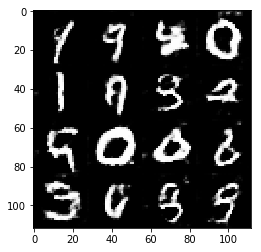

Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.4585
Epoch 2/2... Discriminator Loss: 1.5576... Generator Loss: 2.6615
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 0.9291
Epoch 2/2... Discriminator Loss: 0.7195... Generator Loss: 1.5039
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.2056
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.9602


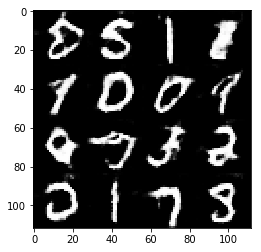

Epoch 2/2... Discriminator Loss: 0.6305... Generator Loss: 1.3332
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.4944
Epoch 2/2... Discriminator Loss: 1.5318... Generator Loss: 0.3415
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.4700
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 1.2581
Epoch 2/2... Discriminator Loss: 0.9980... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.3491
Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 1.3925
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 0.7391


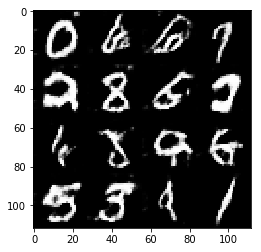

Epoch 2/2... Discriminator Loss: 3.2862... Generator Loss: 0.0695
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 1.4961
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 2.4538
Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 1.1614... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 1.6502
Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 1.0821


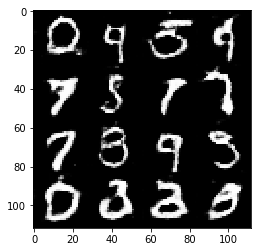

Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 0.7651... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 0.6187... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 2.2164... Generator Loss: 0.1695
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.2029
Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 0.5922... Generator Loss: 2.3036
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 1.2579
Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.6078


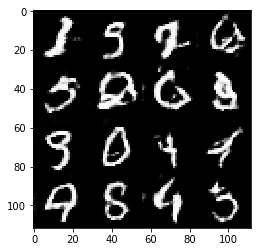

Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 2.0909
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 1.9528
Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 0.5580... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: 0.5652... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 2.4444


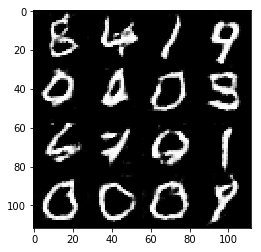

Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 0.5396
Epoch 2/2... Discriminator Loss: 2.0726... Generator Loss: 0.1983
Epoch 2/2... Discriminator Loss: 1.9301... Generator Loss: 0.2506
Epoch 2/2... Discriminator Loss: 0.6010... Generator Loss: 1.8145
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 0.8637
Epoch 2/2... Discriminator Loss: 0.5176... Generator Loss: 1.3976
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 1.1202
saving generator.ckpt


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2412... Generator Loss: 20.2226
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 6.8401
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 2.6977
Epoch 1/1... Discriminator Loss: 0.1175... Generator Loss: 2.7417
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 5.8203
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 2.4874


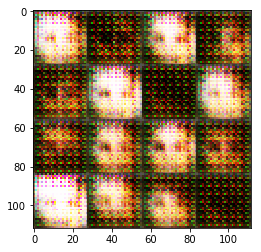

Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 1.8708
Epoch 1/1... Discriminator Loss: 1.6061... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 5.9236... Generator Loss: 12.3708
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.9520... Generator Loss: 6.7956
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 3.1630
Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 1.8431
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 2.4753


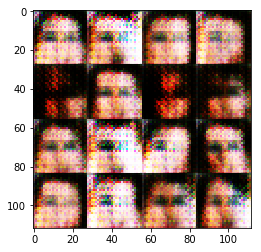

Epoch 1/1... Discriminator Loss: 0.7234... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 2.0227... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 2.0337
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.6206


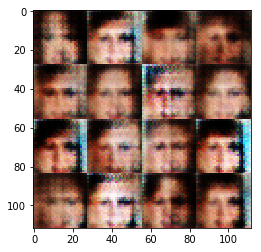

Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 1.8435
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.6162
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.4943
Epoch 1/1... Discriminator Loss: 0.7234... Generator Loss: 1.9356
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6175


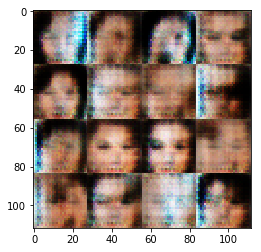

Epoch 1/1... Discriminator Loss: 1.9818... Generator Loss: 0.2688
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.6592
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.5656


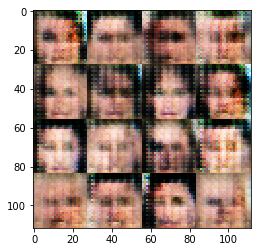

Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 2.7791
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.2344


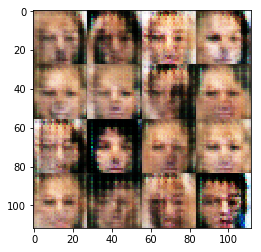

Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 1.7084... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 2.6961
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 2.8989... Generator Loss: 2.3903


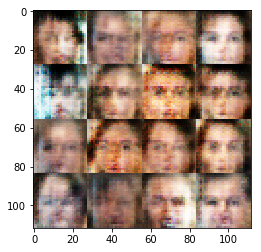

Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.7319... Generator Loss: 0.3044
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7716


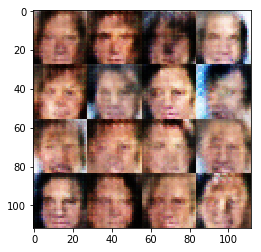

Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.4619
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.1541


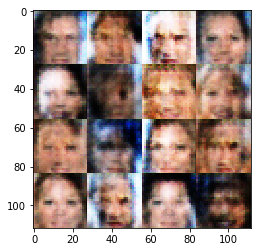

Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.6748... Generator Loss: 0.3677
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.2850


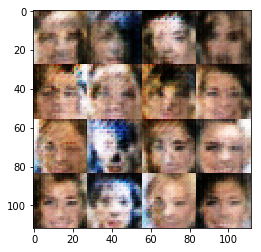

Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.5921
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 2.2802
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 2.0493
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.5908


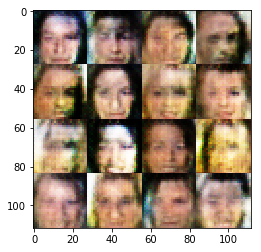

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 2.4527
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7035


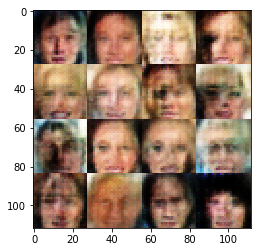

Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 2.3235
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.6018
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.7752... Generator Loss: 0.2545
Epoch 1/1... Discriminator Loss: 1.8727... Generator Loss: 0.2251


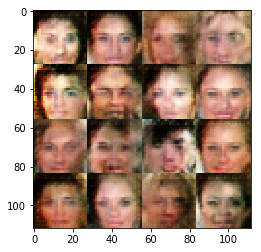

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.4123


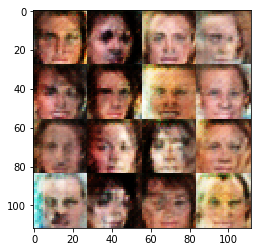

Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.8716


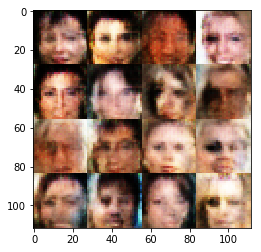

Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8463


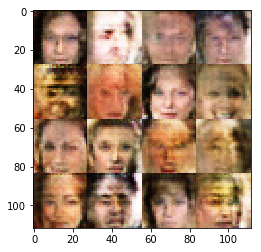

Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.8166... Generator Loss: 0.2343
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.4236


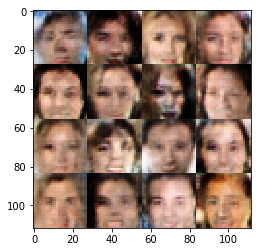

Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.8063... Generator Loss: 0.2729
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.3346
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 1.6738


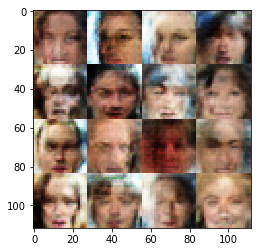

Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.8749


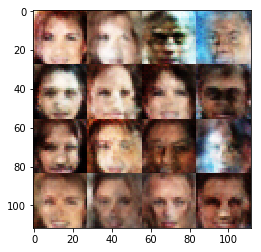

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9445


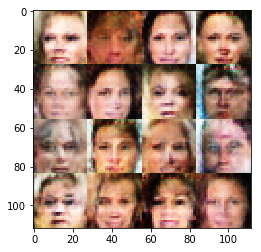

Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 1.9982
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 1.5498
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.3094


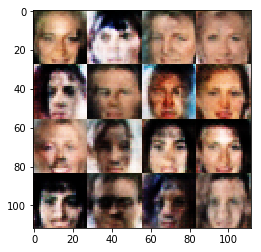

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.4269
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.4468
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 1.5422
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.4421
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.3136


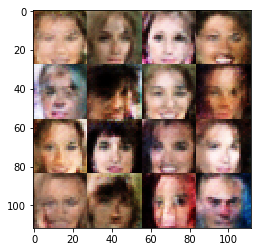

Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.3149
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6492


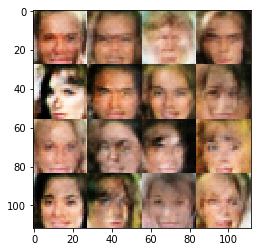

Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.8791


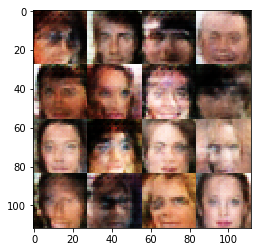

Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.1787


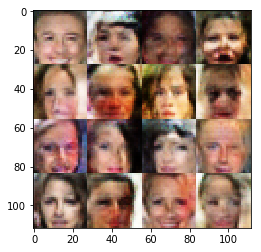

Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.4940


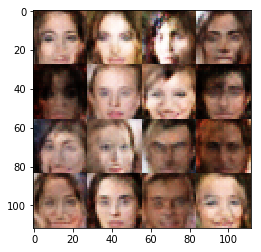

Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.4626
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.3417
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6718


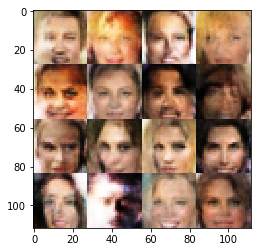

Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.5869


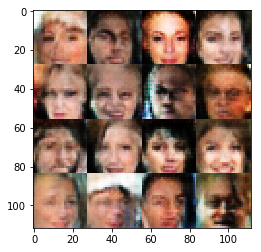

Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.7142... Generator Loss: 1.4560
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.4817


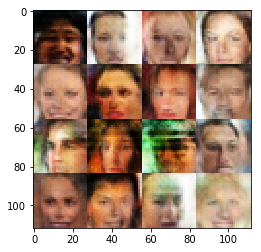

Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 2.0818... Generator Loss: 2.5937
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.8522... Generator Loss: 0.2351


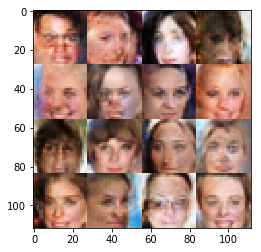

Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.8030


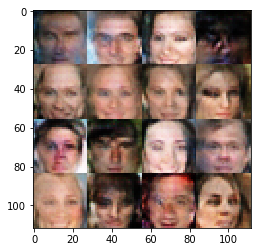

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.9586
saving generator.ckpt


In [23]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.